***
# <font color=red>Building and Explaining a Regressor using AutoMLx</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle AutoMLx Team </font></p>

***

AutoMLx Regression Demo version 23.1.1.

Copyright (c) 2023 Oracle, Inc.  

Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl/

## Overview of this Notebook

In this notebook we will build a regressor using the Oracle AutoMLx tool for the public California Housing dataset to predict the value of house prices.
We explore the various options provided by the Oracle AutoMLx tool, allowing the user to control the AutoML training process. We finally evaluate the different models trained by AutoML. Depending on the dataset size and the machine running it, it can take about tens of minutes. The dataset is sampled down for a snappier demo, with the option to run it with the full dataset. We finally provide an overview of the possibilites that Oracle AutoMLx provides for explaining the predictions of the tuned model.

---
## Prerequisites:

  - Experience level: Novice (Python and Machine Learning)
  - Professional experience: Some industry experience

Compatible conda pack: [Oracle AutoML and Model Explanation for Python 3.8 (version 2.0)](oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/Oracle_AutoML_and_Model_Explanation_for_Python_3.8/2.0/automlx_p38_cpu_v2)

---

## Business Use:

Data analytics and modeling problems using Machine Learning (ML) are becoming popular and often rely on data science expertise to build accurate ML models. Such modeling tasks primarily involve the following steps:
- Preprocess dataset (clean, impute, engineer features, normalize).
- Pick an appropriate model for the given dataset and prediction task at hand.
- Tune the chosen model’s hyperparameters for the given dataset.

All of these steps are significantly time consuming and heavily rely on data scientist expertise. Unfortunately, to make this problem harder, the best feature subset, model, and hyperparameter choice widely varies with the dataset and the prediction task. Hence, there is no one-size-fits-all solution to achieve reasonably good model performance. Using a simple Python API, AutoML can quickly (faster) jump-start the datascience process with an accurately-tuned model and appropriate features for a given prediction task.

## Table of Contents

- <a href='#setup'>0. Setup</a>
- <a href='#load-data'>1. Load California housing dataset</a>
- <a href='#AutoML'>2. AutoML</a>
  - <a href='#Engine'>2.0. Set the Engine</a>
  - <a href='#provider'>2.1. Create an Instance of AutoML</a>
  - <a href='#default'>2.2 Train a Model using AutoML</a>
  - <a href='#analyze'>2.3. Analyze the AutoML optimization process </a>
      - <a href='#algorithm-selection'>2.3.1. Algorithm Selection</a>
      - <a href='#adaptive-sampling'>2.3.2. Adaptive Sampling</a>
      - <a href='#feature-selection'>2.3.3. Feature Selection</a>
      - <a href='#hyperparameter-tuning'>2.3.4. Hyperparameter Tuning</a>
  - <a href='#modellist'>2.4. Provide a Specific Model List </a>
  - <a href='#custom-validation'>2.5. Use a Custom Validation Set </a>
  - <a href='#disablefs'>2.6. Control Feature Selection </a>
  - <a href='#scoringstr'>2.7. Specify a Different Scoring Metric</a>
- <a href='#MLX'>3. Machine Learning Explainability (MLX)</a>
  - <a href='#MLX-initializing'>3.1. Initialize an MLExplainer</a>
  - <a href='#MLX-global'>3.2. Model Explanations (Global Feature Importance)</a>
  - <a href='#MLX-dependency'>3.3. Feature Dependence Explanations (PDP + ICE)</a>
  - <a href='#MLX-local'>3.4. Prediction Explanations (Local Feature Importance)</a>
       - <a href='#MLX-alfi'>3.4.1. Aggregate Local Feature Importance</a>
  - <a href='#MLX-whatif'>3.5. Interactive What-IF Explanations</a>
  - <a href='#MLX-advanced'>3.6. Advanced Feature Importance Options</a>
       - <a href='#MLX-changing'>3.6.1. Change the number of iterations</a>
       - <a href='#MLX-including'>3.6.2. Include the effects of feature interactions (with Shapley feature importance)</a>
       - <a href='#MLX-explain'>3.6.3. Explain the model or explain the world</a>
       - <a href='#MLX-surrogates'>3.6.4. Local explanations with surrogate models (LIME+)</a>
  - <a href='#MLX-advanced-ale'>3.7. Advanced Feature Dependence Options (ALE)</a>       
- <a href='#ref'>References</a>

<a id='setup'></a>
## Setup

Basic setup for the Notebook.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Load the required modules.

In [2]:
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Settings for plots
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['font.size'] = 15
sns.set(color_codes=True)
sns.set(font_scale=1.5)
sns.set_palette("bright")
sns.set_style("whitegrid")

import automl
from automl import init

<a id='load-data'></a>
## Load the California housing dataset using sklearn.datasets

Dataset details are available here: https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset. The goal is to predict the median price of a house given some features.

In [3]:
X, y = fetch_california_housing(return_X_y=True)
ds = fetch_california_housing(return_X_y=False)
df = pd.concat([pd.DataFrame(X, columns=ds.feature_names),
                pd.DataFrame(y.ravel(), columns=['Median Price'])], axis=1)

target_col='Median Price'
df.shape

(20640, 9)

In [4]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Median Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


We first display the density of the target median price.

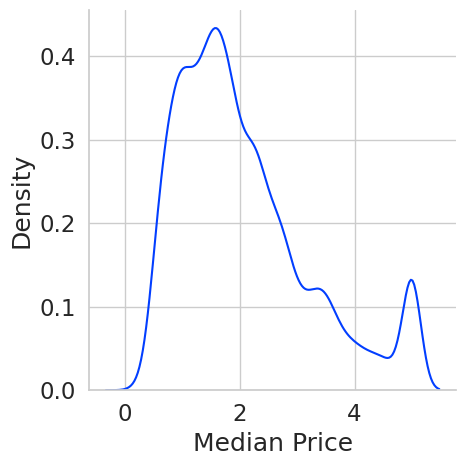

In [5]:
# drop unlabled data in train/test dataset
df = df[df[target_col].notna()]

sns.displot(x=target_col, data=df, kind='kde') # kernel density estimate

We now separate the targets (`y`) from the training features (`X`) and split the dataset into training (70%) and test (30%) datasets. The training set will be used to create a Machine Learning model using Oracle AutoMLx, and the test set will be used to evaluate the model's performance on unseen data.

In [6]:
X_full = df.drop(target_col, axis=1)
y_full = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=7)

X_train.shape, X_test.shape

((14448, 8), (6192, 8))

<a id='AutoML'></a>
## AutoML

<a id='Engine'></a>
### Set the engine
The AutoML pipeline offers the function `init`, which allows to initialize the parallel engine. By default, the AutoML pipeline uses the `dask` parallel engine. One can also set the engine to `local`, which uses python's multiprocessing library for parallelism instead.

In [7]:
init(engine='local')

[2023-03-21 08:25:11,264] [automl.xengine] Local ProcessPool execution (n_jobs=8)


<a id='provider'></a>
### Create an instance of Oracle AutoMLx

The Oracle AutoMLx solution provides a pipeline that automatically finds a tuned model given a prediction task and a training dataset. In particular it allows to find a tuned model for any supervised prediction task, e.g. classification or regression, where the target can be binary, categorical or real-valued.

AutoML consists of five main modules: 
- **Preprocessing** : Clean, impute, engineer, and normalize features.
- **Algorithm Selection** : Identify the right regression algorithm -in this notebook- for a given dataset, choosing from amongst:
    - AdaBoostRegressor
    - DecisionTreeRegressor
    - ExtraTreesRegressor
    - LGBMRegressor
    - LinearSVR
    - LinearRegression
    - RandomForestRegressor
    - SVR
    - XGBRegressor
    - TorchMLPRegressor
- **Adaptive Sampling** : Select a subset of the data samples for the model to be trained on.
- **Feature Selection** : Select a subset of the data features, based on the previously selected model.
- **Hyperparameter Tuning** : Find the right model parameters that maximize score for the given dataset. 


All these pieces are readily combined into a simple AutoML pipeline which automates the entire Machine Learning process with minimal user input/interaction.

<a id='default'></a>
### Train a model using Oracle AutoMLx

The AutoML API is quite simple to work with. We create an instance of AutoML pipeline. Next, the training data is passed to the `fit()` function which successively executes the previously mentioned modules.

In [8]:
est1 = automl.Pipeline(task='regression')
est1.fit(X_train, y_train)

[2023-03-21 08:25:11,416] [automl.pipeline] Random state (7) is used for model builds
[2023-03-21 08:25:11,428] [automl.pipeline] Dataset shape: (14448, 8)
[2023-03-21 08:25:11,438] [automl.pipeline] Running Auto-Preprocessing
[2023-03-21 08:25:11,462] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (14448, 8), cv: [(11558, 2890), (11558, 2890), (11558, 2890), (11559, 2889), (11559, 2889), (11558, 2890), (11558, 2890), (11558, 2890), (11559, 2889), (11559, 2889)]
[2023-03-21 08:25:11,526] [automl.pipeline] SVR, KNeighborsRegressor are disabled for datasets with > 10K samples or > 1K features
[2023-03-21 08:25:11,527] [automl.pipeline] Running Model Selection
[2023-03-21 08:25:24,377] [automl.pipeline] Model Selection completed. Selected model: ['LGBMRegressor']
[2023-03-21 08:25:24,378] [automl.pipeline] Running Adaptive Sampling. Dataset Shape: (14448, 8), Valid Shape: None, CV: [(11558, 2890), (11558, 2890), (11558, 2890), (11559, 2889), (11559, 2889), (11558, 2890)

Pipeline(model_list=['AdaBoostRegressor', 'DecisionTreeRegressor',
                     'ExtraTreesRegressor', 'LGBMRegressor', 'LinearSVR',
                     'LinearRegression', 'RandomForestRegressor', 'SVR',
                     'XGBRegressor', 'TorchMLPRegressor'])

A model is then generated (`est1`) and can be used for prediction tasks. We use the `mean_squared_error` scoring metric to evaluate the performance of this model on unseen data (`X_test`).

In [9]:
y_pred = est1.predict(X_test)
score_default = mean_squared_error(y_test, y_pred)

print(f'Mean squared error on test data : {score_default}')

Mean squared error on test data : 0.19959317236382942


<a id='analyze'></a>
### Analyze the AutoML optimization process

During the Oracle AutoMLx process, a summary of the optimization process is logged, containing:
- Information about the training data.
- Information about the AutoML Pipeline, such as:
    - Selected features that the pipeline found to be most predictive in the training data;
    - Selected algorithm that was the best choice for this data;
    - Selected hyperparameters for the selected algorithm.

AutoML provides a `print_summary` API to output all the different trials performed.

In [10]:
est1.print_summary()

Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time,Memory Usage (GB)
LGBMRegressor_HT,14448,6,-0.2017,"{'boosting_type': 'gbdt', 'colsample_bytree': 0.7952797110155084, 'max_depth': 63, 'n_estimators': 377, 'num_leaves': 31, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1}",6.8841,"(0.0, None)"
LGBMRegressor_HT,14448,6,-0.2017,"{'boosting_type': 'gbdt', 'colsample_bytree': 1, 'max_depth': 18, 'n_estimators': 377, 'num_leaves': 31, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1}",6.6678,"(0.0, None)"
LGBMRegressor_HT,14448,6,-0.2018,"{'boosting_type': 'gbdt', 'colsample_bytree': 1, 'max_depth': 63, 'n_estimators': 377, 'num_leaves': 31, 'reg_alpha': 1.8534128133509583e-05, 'reg_lambda': 0, 'subsample': 1}",7.3414,"(0.0, None)"
LGBMRegressor_HT,14448,6,-0.2018,"{'boosting_type': 'gbdt', 'colsample_bytree': 1, 'max_depth': 63, 'n_estimators': 377, 'num_leaves': 31, 'reg_alpha': 1.778506445476284e-05, 'reg_lambda': 0, 'subsample': 1}",6.8606,"(0.0, None)"
LGBMRegressor_HT,14448,6,-0.2018,"{'boosting_type': 'gbdt', 'colsample_bytree': 1, 'max_depth': 63, 'n_estimators': 377, 'num_leaves': 31, 'reg_alpha': 1.778412806339553e-05, 'reg_lambda': 0, 'subsample': 1}",7.1095,"(0.0, None)"
...,...,...,...,...,...,...
LGBMRegressor_HT,14448,6,-0.9325,"{'boosting_type': 'dart', 'colsample_bytree': 0.4, 'max_depth': 2, 'n_estimators': 5, 'num_leaves': 7, 'reg_alpha': 1e-10, 'reg_lambda': 0.0056245538305564015, 'subsample': 0.4}",0.1881,"(0.0, None)"
LGBMRegressor_HT,14448,6,-0.9797,"{'boosting_type': 'dart', 'colsample_bytree': 0.7952737110155085, 'max_depth': 2, 'n_estimators': 5, 'num_leaves': 7, 'reg_alpha': 1e-10, 'reg_lambda': 1e-10, 'subsample': 0.4}",0.1960,"(0.0, None)"
LGBMRegressor_HT,14448,6,-0.9797,"{'boosting_type': 'dart', 'colsample_bytree': 0.7952797110155084, 'max_depth': 2, 'n_estimators': 5, 'num_leaves': 7, 'reg_alpha': 1e-10, 'reg_lambda': 1e-10, 'subsample': 0.4}",0.2028,"(0.0, None)"
LinearRegression_AS,5000,8,-1.2614,{},0.0685,0.0


We also provide the capability to visualize the results of each stage of the AutoML pipeline. 

<a id='algorithm-selection'></a>
#### Algorithm Selection

The plot below shows the scores predicted by Algorithm Selection for each algorithm. The horizontal line shows the average score across all algorithms. Algorithms below the line are colored turquoise, whereas those with a score higher than the mean are colored teal. Here we can see that the `LGBMRegressor` achieved the highest predicted score (orange bar), and is chosen for subsequent stages of the Pipeline.

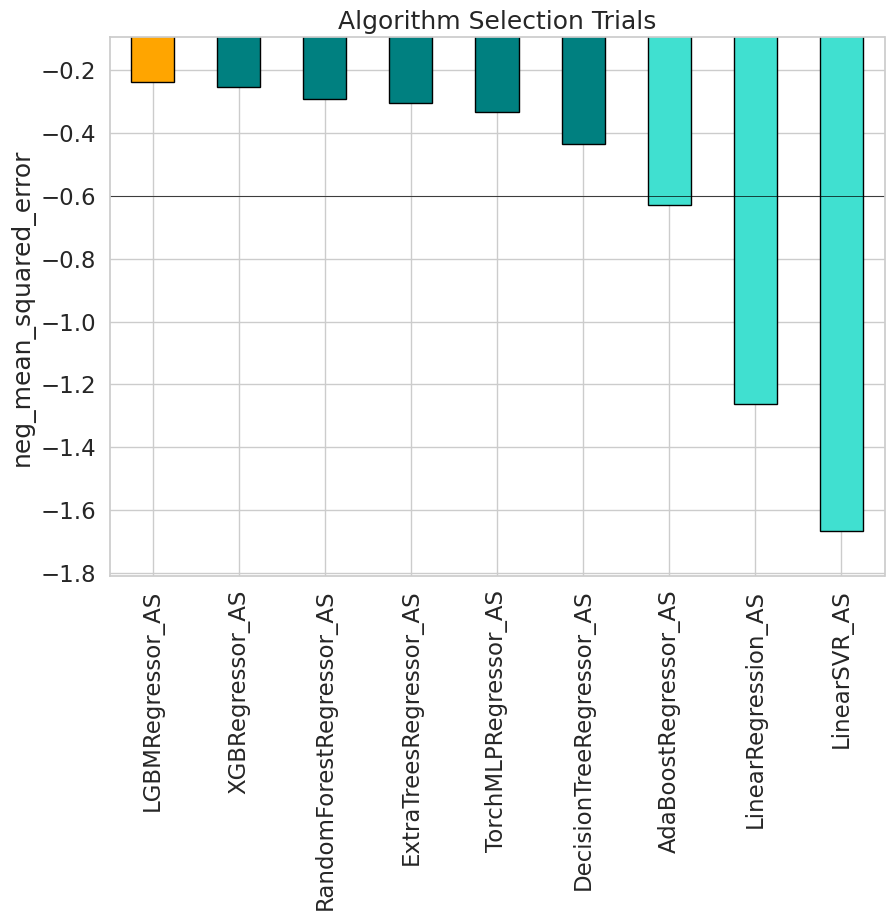

In [11]:
# Each trial is a tuple of
# (algorithm, no. samples, no. features, mean CV score, hyperparameters, 
# all CV scores, total CV time (s), memory usage (Gb))
trials = est1.model_selection_trials_ 
scores = [x[3] for x in trials]
models = [x[0] for x in trials]
y_margin = 0.10 * (max(scores) - min(scores))
s = pd.Series(scores, index=models).sort_values(ascending=False)

colors = []
for f in s.keys():
    if f == '{}_AS'.format(est1.selected_model_):
        colors.append('orange')
    elif s[f] >= s.mean():
        colors.append('teal')
    else:
        colors.append('turquoise')
        

fig, ax = plt.subplots(1)
ax.set_title("Algorithm Selection Trials")
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.set_ylabel(est1.inferred_score_metric[0])
s.plot.bar(ax=ax, color=colors, edgecolor='black')
ax.axhline(y=s.mean(), color='black', linewidth=0.5)
plt.show()

<a id='adaptive-sampling'></a>
#### Adaptive Sampling

Following Algorithm Selection, Adaptive Sampling aims to find the smallest dataset sample that can be created without compromising validation set score for the chosen model (`LGBMRegressor`). In this case, no subset is found to keep sufficient validation score, so we continue with the entire dataset.

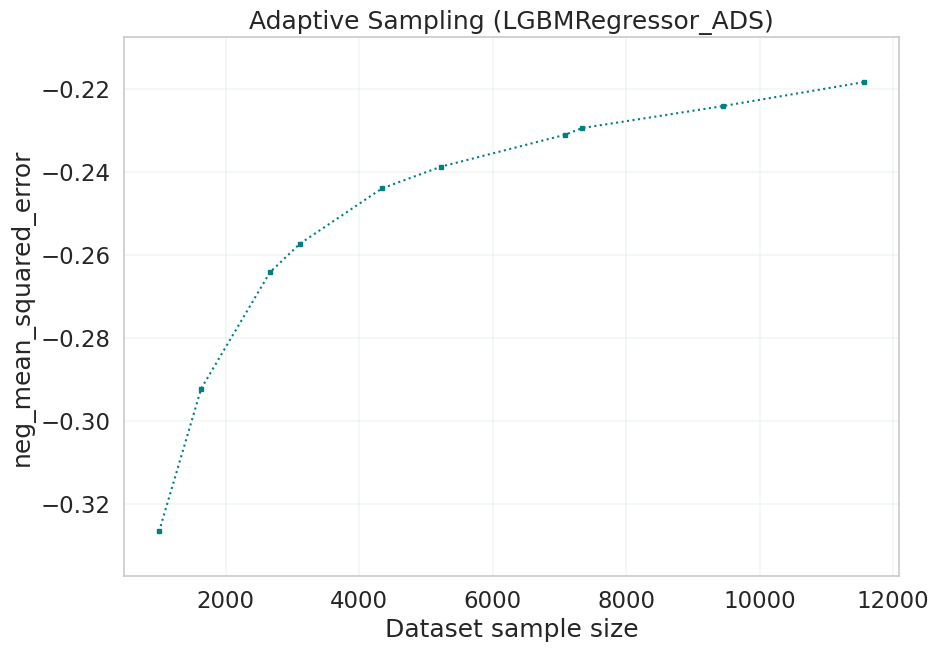

In [12]:
# Each trial is a tuple of
# (algorithm, no. samples, no. features, mean CV score, hyperparameters, 
# all CV scores, total CV time (s), memory usage (Gb))
trials = est1.adaptive_sampling_trials_
scores = [x[3] for x in trials]
n_samples = [x[1] for x in trials]
y_margin = 0.10 * (max(scores) - min(scores))

fig, ax = plt.subplots(1)
ax.set_title("Adaptive Sampling ({})".format(trials[0][0]))
ax.set_xlabel('Dataset sample size')
ax.set_ylabel(est1.inferred_score_metric[0])
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.plot(n_samples, scores, 'k:', marker="s", color='teal', markersize=3)
plt.show()

<a id='feature-selection'></a>
#### Feature Selection

The next step of the pipeline is to find a relevant feature subset to maximize score for the chosen algorithm. AutoMLx Feature Selection follows an intelligent search strategy, looking at various possible feature rankings and subsets, and identifying that smallest feature subset that does not compromise on score for the chosen algorithm (`LGBMRegressor`). The orange line shows the optimal number of features chosen by Feature Selection (in this case 6 features, droppping `AveBedrms` and `Population`).

Features selected: ['MedInc', 'HouseAge', 'AveRooms', 'AveOccup', 'Latitude', 'Longitude']
Features dropped: ['AveBedrms', 'Population']


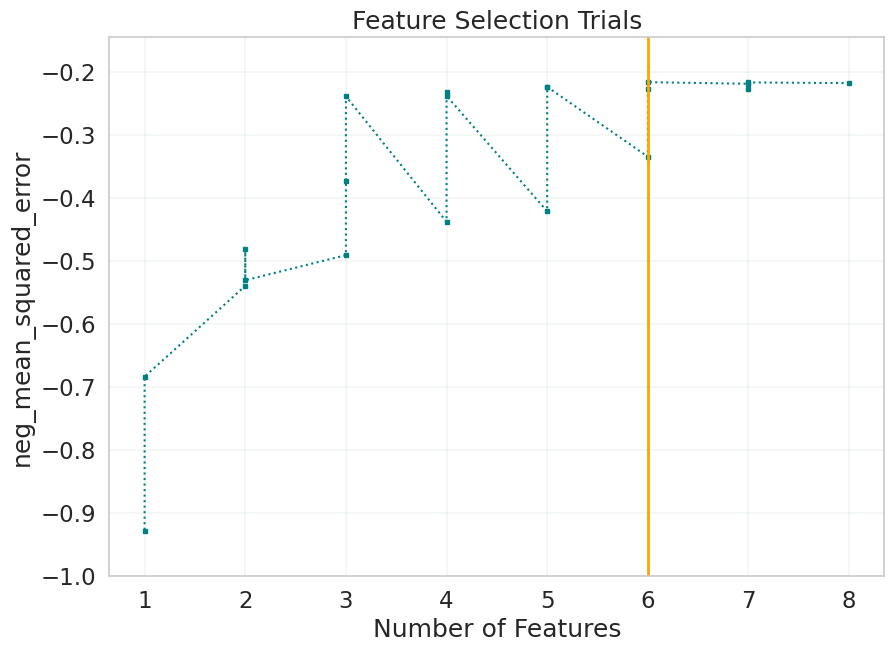

In [13]:
print(f"Features selected: {est1.selected_features_names_.to_list()}")
dropped_features = est1.pipeline.preprocessor.transformed_col_names.drop(est1.selected_features_names_)
print(f"Features dropped: {dropped_features.to_list()}")

# Each trial is a tuple of
# (algorithm, no. samples, no. features, mean CV score, hyperparameters, 
# all CV scores, total CV time (s), memory usage (Gb))
trials = est1.feature_selection_trials_
scores = [x[3] for x in trials]
n_features = [x[2] for x in trials]
y_margin = 0.10 * (max(scores) - min(scores))


fig, ax = plt.subplots(1)
ax.set_title("Feature Selection Trials")
ax.set_xlabel("Number of Features")
ax.set_ylabel(est1.inferred_score_metric[0])
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.plot(n_features, scores, 'k:', marker="s", color='teal', markersize=3)
ax.axvline(x=len(est1.selected_features_names_), color='orange', linewidth=2.0)
plt.show()

<a id='hyperparameter-tuning'></a>
#### Hyperparameter Tuning

Hyperparameter Tuning is the last stage of the AutoML pipeline, and focuses on improving the chosen algorithm's score on the reduced dataset (after Adaptive Sampling and Feature Selection). We use a novel iterative algorithm to search across many hyperparameter dimensions, and converge automatically when optimal hyperparameters are identified. Each trial in the graph below represents a particular hyperparameter configuration for the selected model.

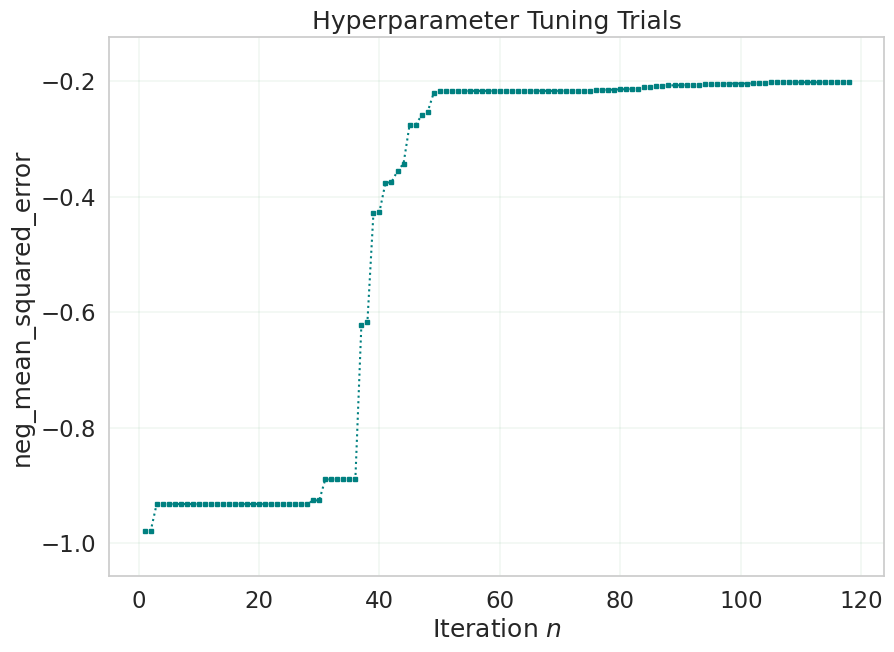

In [14]:
# Each trial is a tuple of
# (algorithm, no. samples, no. features, mean CV score, hyperparameters, 
# all CV scores, total CV time (s), memory usage (Gb))
trials = est1.tuning_trials_
scores = [x[3] for x in reversed(trials)]
y_margin = 0.10 * (max(scores) - min(scores))


fig, ax = plt.subplots(1)
ax.set_title("Hyperparameter Tuning Trials")
ax.set_xlabel("Iteration $n$")
ax.set_ylabel(est1.inferred_score_metric[0])
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.plot(range(1, len(trials) + 1), scores, 'k:', marker="s", color='teal', markersize=3)
plt.show()

<a id='modellist'></a>
### Provide a specific model list to AutoML
The Oracle AutoMLx solution also supports a `model_list` argument, allowing you to control what algorithms AutoML considers during its optimization process. `model_list` is specified as a list of strings, which can be any combination of 

- AdaBoostRegressor
- DecisionTreeRegressor
- ExtraTreesRegressor
- LGBMRegressor
- LinearSVR
- LinearRegression
- RandomForestRegressor
- SVR
- XGBRegressor
- TorchMLPRegressor

Here, we ask AutoML to only consider `LinearRegression`. Note that it does not perform well compared to the full capabilites of the AutoML pipeline.

In [15]:
est2 = automl.Pipeline(task='regression', model_list=['LinearRegression'])
est2.fit(X_train, y_train)
y_pred = est2.predict(X_test)
score_modellist = mean_squared_error(y_test, y_pred)

print(f'Prediction error (mse) on test data : {score_modellist}')

[2023-03-21 08:29:40,095] [automl.pipeline] Random state (7) is used for model builds
[2023-03-21 08:29:40,108] [automl.pipeline] Dataset shape: (14448, 8)
[2023-03-21 08:29:40,118] [automl.pipeline] Running Auto-Preprocessing
[2023-03-21 08:29:40,141] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (14448, 8), cv: [(11558, 2890), (11558, 2890), (11558, 2890), (11559, 2889), (11559, 2889), (11558, 2890), (11558, 2890), (11558, 2890), (11559, 2889), (11559, 2889)]
[2023-03-21 08:29:40,159] [automl.pipeline] SVR, KNeighborsRegressor are disabled for datasets with > 10K samples or > 1K features
[2023-03-21 08:29:40,160] [automl.pipeline] Running Model Selection
[2023-03-21 08:29:40,161] [automl.pipeline] Algorithm Selection Disabled
[2023-03-21 08:29:40,162] [automl.pipeline] User provided model LinearRegression is the only desired model
[2023-03-21 08:29:40,166] [automl.pipeline] Model Selection completed. Selected model: ['LinearRegression']
[2023-03-21 08:29:40,167] [

<a id='custom-validation'></a>
### Use a custom validation set
You can specify a custom validation set that you want AutoML to use to evaluate the quality of models and configurations. 


In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.7, random_state=0)

In [17]:
est3 = automl.Pipeline(task='regression')
est3.fit(X_train, y_train, X_val, y_val)

y_pred = est3.predict(X_test)
score = mean_squared_error(y_test, y_pred)

print(f'Prediction error (MSE) on test data : {score}')

[2023-03-21 08:29:45,806] [automl.pipeline] Random state (7) is used for model builds
[2023-03-21 08:29:45,817] [automl.pipeline] Dataset shape: (10113, 8)
[2023-03-21 08:29:45,835] [automl.pipeline] Running Auto-Preprocessing
[2023-03-21 08:29:45,877] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (10113, 8), cv: None
[2023-03-21 08:29:45,921] [automl.pipeline] SVR, KNeighborsRegressor are disabled for datasets with > 10K samples or > 1K features
[2023-03-21 08:29:45,922] [automl.pipeline] Running Model Selection
[2023-03-21 08:29:50,638] [automl.pipeline] Model Selection completed. Selected model: ['LGBMRegressor']
[2023-03-21 08:29:50,639] [automl.pipeline] Running Adaptive Sampling. Dataset Shape: (10113, 8), Valid Shape: (4335, 8), CV: None, Class counts: N/A
[2023-03-21 08:40:19,099] [automl.pipeline] Adaptive Sampling Completed. Updated Dataset Shape: (10113, 8), Valid Shape: (1667, 8), CV: None, Class counts: N/A
[2023-03-21 08:40:19,100] [automl.pipeline] St

<a id='disablefs'></a>
### Control the Feature Selection Stage in AutoML
Similarly the user can control the Feature Selection stage of the AutoML Pipeline. This can be achieved by using the `min_features` argument when initializing the Pipeline. Setting it to 1.0 will disable Feature selection.

In [ ]:
est4 = automl.Pipeline(task='regression', min_features=1.0)
est4.fit(X_train, y_train, X_val, y_val)
y_pred = est4.predict(X_test)

score = mean_squared_error(y_test, y_pred)

print(f'Prediction error (MSE) on test data : {score}')

[2023-03-21 08:42:06,968] [automl.pipeline] Random state (7) is used for model builds
[2023-03-21 08:42:06,984] [automl.pipeline] Dataset shape: (10113, 8)
[2023-03-21 08:42:06,995] [automl.pipeline] Running Auto-Preprocessing
[2023-03-21 08:42:07,021] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (10113, 8), cv: None
[2023-03-21 08:42:07,048] [automl.pipeline] SVR, KNeighborsRegressor are disabled for datasets with > 10K samples or > 1K features
[2023-03-21 08:42:07,049] [automl.pipeline] Running Model Selection
[2023-03-21 08:42:10,378] [automl.pipeline] Model Selection completed. Selected model: ['LGBMRegressor']
[2023-03-21 08:42:10,379] [automl.pipeline] Running Adaptive Sampling. Dataset Shape: (10113, 8), Valid Shape: (4335, 8), CV: None, Class counts: N/A


<a id='scoringstr'></a>
### Specify a different scoring metric to AutoML
The Oracle AutoMLx tool tries to maximize a given scoring metric, by looking at different algorithms, features and hyperparameter choices. By default, the score metric is set to `neg_mean_squared_error` for regression. 
The user can also choose a metric using `score_metric`. The scoring metric can be specified as a string. For regression, supported metrics are

- 'neg_mean_absolute_error'
- 'neg_mean_squared_error' 
- 'neg_mean_squared_log_error'
- 'neg_median_absolute_error'
- 'r2'

Detailed documentation about scoring metrics: https://scikit-learn.org/stable/modules/classes.html#regression-metrics.
Here we ask AutoML to optimize for the `r2` scoring metric.

In [ ]:
est5 = automl.Pipeline(task='regression', score_metric='r2')
est5.fit(X_train, y_train, X_val, y_val)
y_pred = est5.predict(X_test)

score_scoringstr = mean_squared_error(y_test, y_pred)

print(f'Prediction error (MSE) on test data : {score_scoringstr}')

<a id='MLX'></a>
## Machine Learning Explainability

For a variety of decision-making tasks, getting only a prediction as model output is not sufficient. A user may wish to know why the model outputs that prediction, or which data features are relevant for that prediction. For that purpose the Oracle AutoMLx solution defines the `MLExplainer` object, which allows to compute multiple types of model explanations.

<a id='MLX-initializing'></a>
### Initialize an MLExplainer

The `MLExplainer` object takes as argument the trained model, the training data and labels, as well as the task.

In [ ]:
explainer = automl.MLExplainer(est1,
                               X_train,
                               y_train,
                               target_names=['Median Price'],
                               task="regression")

<a id='global'></a>
### Model Explanations (Global Feature importance)

The notion of Global Feature Importance intuitively measures how much the model's performance (relative to the provided train labels) would change if a given feature were dropped from the dataset, <b><i>without</i></b> allowing the model to be retrained. This notion of feature importance considers each feature independently from all other features. 

#### Compute the importance

By default we use a permutation method to successively measure the importance of each feature. Such a method therefore runs in linear time with respect to the
number of features in the dataset. 

The method `explain_model()` allows to compute such feature importances. It also provides 95% confidence intervals for each feature importance.

In [ ]:
result_explain_model_default = explainer.explain_model()

#### Visualization

There are two options to show the explanation's results:
- `to_dataframe()` will return a dataframe of the results.
- `show_in_notebook()` will show the results as a bar plot.

The features are returned in decreasing order of importance. We see that `Latitude` and `Longitude` are considered to be the most important features.

In [ ]:
result_explain_model_default.to_dataframe()

In [ ]:
result_explain_model_default.show_in_notebook()

<a id='MLX-dependency'></a>
### Feature Dependence Explanations (PDP + ICE)

Another way to measure dependency on a feature is through a partial dependence plot (PDP) or an individual conditional expectation (ICE) plot. For accumulated local effects (ALE) explanations, see <a href='#MLX-advanced-ale'>Advanced Feature Dependence Options (ALE)</a>

Given a dataset, a PDP displays the average output of the model as a function of the value of the selected set of features. 

It can be computed for a single feature, as in the cell below. The X-axis is the value of the `Latitude` feature and the y-axis is the corresponding outputted price. Since we are considering the whole dataset, the average over outputs is given by the red line, while the shaded interval corresponds to a 95% confidence interval for the average.

The histogram on top shows the distribution of the value of the `Latitude` feature in the dataset.

In [ ]:
result_explain_feature_dependence_default = explainer.explain_feature_dependence('Latitude')
result_explain_feature_dependence_default.show_in_notebook()

The ICE plot is automatically computed at the same time as any one-feature PDP. It can be accessed by passing `ice=True` to `show_in_notebook`. 

Similar to PDPs, ICE plots show the median prediction as a model red line. However, the variance in the model's predictions are shown by plotting the predictions of a sample of individual data instances as light grey lines. (For categorical features, the distribution in the predictions is instead shown as a violin plot.)

In [ ]:
result_explain_feature_dependence_default.show_in_notebook(ice=True)

We can also plot the PDP for multiple features. The plot below is the PDP for the `Latitude` and `Longitude` features. The X-axis still shows the values of `Latitude`, while there is a different curve and confidence interval for each value of the feature `Longitude`.

The histogram displays the joint distribution of the two features.

In [ ]:
result_explain_feature_dependence_default = explainer.explain_feature_dependence(['Latitude', 'Longitude'])
result_explain_feature_dependence_default.show_in_notebook()

PDPs can be computed for an arbitrary number of variables; however, they can only be visualized with up to 4. Here, we show an example with 3 features.

In [ ]:
result_explain_feature_dependence_default = explainer.explain_feature_dependence(['MedInc', 'HouseAge', 'AveOccup'])
result_explain_feature_dependence_default.show_in_notebook()

<a id='MLX-local'></a>
###  Prediction Explanations (Local Feature Importance)

Given a data sample, one can also obtain the local importance, which is the importance of the features for the model's prediction on that sample.
In the following cell, we consider sample $0$. The function `explain_prediction()` computes the local importance for a given sample.

`Latitude=34.02` means that the value of feature `Latitude` for that sample is `34.02`. Removing that feature would change the model's prediction by the magnitude of the bar. That is, in this case, the model's prediction for the median house price is approximately 1.15 (i.e., $115 000) less because the model knows the value of `Latitude` is `34.02`.  

In [ ]:
index = 0
result_explain_prediction_default = explainer.explain_prediction(X_train.iloc[index:index + 1, :])
result_explain_prediction_default[0].show_in_notebook()

<a id='MLX-alfi'></a>
### Aggregate Local Feature Importance
We now summarize all of the individual local feature importance explanations into one single aggregate explanation.

In [ ]:
# We select 10 random instances here as an example and show the aggregate explanation of those instances.
local_explanations = explainer.explain_prediction(X_train.sample(n=10))
alfi = explainer.aggregate(explanations=local_explanations)
alfi.show_in_notebook()

<a id='MLX-whatif'></a>
## Interactive What-If Explanations

The Oracle AutoMLx solution offers also What-IF tool to explain a trained ML model's predictions through a simple interactive interface.

You can use What-IF explainer to explore and visualize immediately how changing a sample value will affect the model's prediction. Furthermore, What-IF can be used to visualize how model's predictions are related to any feature of the dataset.

In [ ]:
explainer.explore_whatif(X_test, y_test)

<a id='MLX-advanced'></a>
### Advanced Feature Importance Options

We now display more advanced configuration for computing feature importance. Here, we will explain a custom `LinearRegression` estimator from `scikit-learn`. Note that the `MLExplainer` object is capable of explaining any regression model, as long as the model follows a scikit-learn-style interface with the `predict` function.

In [ ]:
scikit_model = LinearRegression()
scikit_model.fit(X_train, y_train)

explainer_sklearn = automl.MLExplainer(scikit_model,
                                       X_train,
                                       y_train,
                                       target_names=['Median Price'],
                                       task="regression")

<a id='MLX-changing'></a>
#### Change the number of iterations

One can modify the number of iterations `n_iter` used to evaluate the global importance of the model, or the local importance of a prediction.

Increasing `n_iter` requires a linear increase in computation time. It however provides more
accurate importance estimates, thereby decreasing the variance in repeated calls to
`explain_model`/`explain_prediction`.

The default value is `auto`, which selects a suitable default value based on the choice of
the method of explanation.

In [ ]:
result_explain_model_increase_n_iter = explainer_sklearn.explain_model(n_iter=20)
result_explain_model_increase_n_iter.show_in_notebook()

<a id='MLX-including'></a>
#### Include the effects of feature interactions (with Shapley feature importance)

The Oracle AutoMLx solution allows one to change the effect of feature interactions. This can be done through the `tabulator_type` argument of both global and local importance methods. 

`tabulator_type` can be set to one of the following options:
          
- `permutation`: This value is the default method in the MLExplainer object, with the behaviour described above

- `shapley`: Feature importance is computed using the popular game-theoretic Shapley value method. Technically, this measures the importance of each feature while including the effect of all feature interactions. As a result, it runs in exponential time with respect to the number of features in the dataset. This method also includes the interaction effects of the other features, which means that if two features contain duplicate information, they will be less important. Note that the interpretation of this method's result is a bit different from the permutation method's result. An interested reader may find <a href='https://christophm.github.io/interpretable-ml-book/shapley.html'>this</a> a good source for learning more about it.

- `kernel_shap`: Feature importance attributions will be calculated using an approximation of the Shapley value method. It typically provides relatively high-quality approximations; however, it currently does not provide confidence intervals.
            
- `shap_pi`: Feature importance attributions will be computed using an approximation of the Shapley value method. It runs in linear time, but may miss the effect of interactions between some features, which may therefore produce lower-quality results. Most likely, you will notice that this method yields larger confidence intervals than the other two.

**Summary: `permutation` can miss important features for AD. Exact SHAP (`shapley`) doesn't, but it is exponential. `kernel_shap` is an approximation of exact SHAP method that does not provide confidence intervals. `shap_pi` is linear, thus faster than exact SHAP and kernel_shap but unstable and very random leads to lower quality approximations.**

<a id='MLX-advance-tabulator-prediction'></a>
##### Local feature importance with kernel_shap

In [ ]:
explainer_sklearn.configure_explain_prediction(tabulator_type="kernel_shap")

In [ ]:
index = 0
result_explain_prediction_kernel_shap = explainer_sklearn.explain_prediction(X_train.iloc[index:index+1, :])
result_explain_prediction_kernel_shap[0].show_in_notebook()

<a id='MLX-explain'></a>
#### Explain the model or Explain the world

Oracle AutoMLx solution also provides the `evaluator_type` attribute, which allows one to choose whether to get feature importance attributions that explain exactly which features the model has learned to use (`interventional`), or which features the model or a retrained model could have learned to use (`observational`).
          
- `interventional` : The computed feature importances are as faithful to the
    model as possible. That is, features that are ignored by
    the model will not be considered important. This setting
    should be preferred if the primary goal is to learn about
    the machine learning model itself. Technically, this
    setting is called 'interventional', because the method will
    intervene on the data distribution when assessing the
    importance of features. The intuition of feature importance attributions computed with this method is that the features are dropped from the dataset and the model is not allowed to retrain.

- `observational` : The computed feature importances are more faithful to
    the relationships that exist in the real world (i.e., relationships
    observed in the dataset), even if your specific model did not learn
    to use them. For example, when using a permutation tabulator, a feature
    that is used by the model will not show a large impact on the model's
    performance if there is a second feature that contains near-duplicate
    information, because a re-trained model could have learned to use the
    other feature instead. (Similarly, for Shapley-based tabulators, a 
    feature that is ignored by the model may have a non-zero feature
    importance if it could have been used by the model to
    predict the target.) This setting should be preferred if the
    model is merely a means to learn more about the
    relationships that exist within the data. Technically, this
    setting is called 'observational', because it observes the
    relationships in the data without breaking the existing
    data distribution.

<a id='MLX-advance-evaluator-model'></a>
##### Explain the model with observational evaluator_type

In [ ]:
explainer_sklearn.configure_explain_model(evaluator_type="observational")

In [ ]:
result_explain_model_kernel_shap = explainer_sklearn.explain_model()
result_explain_model_kernel_shap.show_in_notebook()

<a id='MLX-advance-evaluator-prediction'></a>
##### Explain predictions with observational evaluator_type

In [ ]:
explainer_sklearn.configure_explain_prediction(evaluator_type="observational",
                                               tabulator_type="permutation")

In [ ]:
index = 0
result_explain_prediction_kernel_shap = explainer_sklearn.explain_prediction(X_train.iloc[index:index+1, :])
result_explain_prediction_kernel_shap[0].show_in_notebook()

<a id='MLX-surrogates'></a>
#### Local feature importance using surrogate models (LIME+)

The Oracle AutoMLx solution allows one to change the type of local explainer effect of feature interactions. This can be done through the `explainer_type` argument of local importance methods. 

`explainer_type` can be set to one of the following options:
          
- `perturbation`: This value is the default explainer type in local feature importance. As we showed above, the explanation(s) will be computed by perturbing the features of the indicated data instance(s) and measuring the impact on the model predictions.

- `surrogate`: The LIME-style explanation(s) will be computed by fitting a surrogate model to the predictions of the original model in a small region around the indicated data instance(s) and measuring the importance of the features to the interpretable surrogate model. The method of surrogate explainer can be set to one of the following options:
  - `systematic`: An Oracle-labs-improved version of LIME that uses a systematic sampling and custom sample weighting. (Default)
  - `lime`: Local interpretable model-agnostic explanations (LIME) algorithm (https://arxiv.org/pdf/1602.04938).

In [ ]:
explainer_sklearn.configure_explain_prediction(explainer_type='surrogate')

In [ ]:
index = 0
result_explain_prediction_surrogate_lime = explainer_sklearn.explain_prediction(X_train.iloc[index:index+1, :])
result_explain_prediction_surrogate_lime[0].show_in_notebook()

<a id='MLX-advance-evaluator-prediction'></a>
##### Explain predictions with surrogate explainer_type (systematic)

In [ ]:
explainer_sklearn.configure_explain_prediction(explainer_type='surrogate',
                                               method='systematic')

In [ ]:
index = 0
result_explain_prediction_surrogate_systematic = explainer_sklearn.explain_prediction(X_train.iloc[index:index + 1, :])
result_explain_prediction_surrogate_systematic[0].show_in_notebook()

<a id='MLX-advanced-ale'></a>
### Advanced Feature Dependence Options (ALE)

We now show how to use an alternative method for computing feature dependence: accumulated local effects (ALE). ALE explanations are sometimes considered a better alternative to PDPs when features are correlated, because it does not evaluate the model outside of its training distribution in these cases. For more information, see https://christophm.github.io/interpretable-ml-book/ale.html.

Given a dataset, an ALE displays the average change in the output of the model, accumulated over multiple small changes in one or two features, when all other features are held fixed. By default, the ALE explanations are centered around 0, and thus, unlike PDPs, ALEs show the change in the prediction measured by changing a given feature, rather than the average model's prediction for a particular feature value.

#### One-feature ALEs

It can be computed for a single feature, as in the cell below. The X-axis is the value of the `Latitude` feature and the y-axis is the corresponding computed ALE (price unit).

The histogram on top shows the distribution of the value of the `Latitude` feature in the dataset.

In [ ]:
explainer_sklearn.configure_explain_feature_dependence(explanation_type='ale')
result_explain_feature_dependence_default = explainer_sklearn.explain_feature_dependence('Latitude')
result_explain_feature_dependence_default.show_in_notebook()

#### Two-feature ALEs

We can also compute ALEs for two features (At least one is numerical). The plot below is the ALE plot for the `Latitude` and `Longitude` features. The X-axis still shows the values of `Latitude`, while there is multiple lines, one for each value of the feature `Longitude`.

The histogram displays the joint distribution of the two features.

In [ ]:
result_explain_feature_dependence_default = explainer_sklearn.explain_feature_dependence(['Latitude', 'Longitude'])
result_explain_feature_dependence_default.show_in_notebook()

<a id='ref'></a>
## References
* More examples and details: http://automl.oraclecorp.com/
* Oracle AutoML http://www.vldb.org/pvldb/vol13/p3166-yakovlev.pdf
* scikit-learn https://scikit-learn.org/stable/
* Interpretable Machine Learning https://christophm.github.io/interpretable-ml-book/
* LIME https://arxiv.org/pdf/1602.04938